# Introduction

The purpose of this notebook is twofold:

1) Show how to run simulations of the model presented in the main manuscript.
2) Analyse MCMC outputs

In [11]:
# load generic modules
import os
import sys
import json
import emcee # this is the same package used for inference
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
from scipy.special import gammaincc

Functions to simulate H9N2 AIV transmission in a poultry market are found in a module named `simulate_experiment`, which is a wrapper around som C++ code.

Before importing `simulate_experiment`, the underlying C++ code it depends on must be compiled first using `make` (see README). Compilation requires [`pybind11`](https://github.com/pybind/pybind11).

After compilation succeeds, `simulate_experiment` can be imported as any other Python module.

In [110]:
# load functions from simulate experiment
path_lib = os.path.join('/', *os.getcwd().split('/')[1:-1], 'simulator', 'lib' )
if path_lib not in sys.path:
    sys.path.append( path_lib )
from simulate_experiment import simulate_experiment_multispecies_newintro, measure_exposure_multispecies, simulate_market, simulate_market_environment, simulate_market_withclosure, simulate_market_environment_withclosure

In [14]:
# some functions used throughout the notebook

def inv_prob(x):
    return np.exp( x ) / ( 1 + np.exp( x ) ) 

def mean_exp( a, lam, k, dt = 0. ):
    # this is the average of exp(-ax) over f(x+dt|lam,k)/P(x>dt|lam,k),                                                                                       
    # where f is a gamma distribution                                                                                                                         
    return np.exp( a * dt ) * np.power( lam / ( lam + a ), k ) * gammaincc( k, ( lam + a ) * dt ) / gammaincc( k, lam * dt )

def mean_xexp( a, lam, k, dt = 0. ):
    # this is the average of x*exp(-ax) over f(x+dt|lam,k)/P(x>dt|lam,k),                                                                                     
    # where f is a gamma distribution                                                                                                                         

    A = np.exp( a * dt ) * np.power( lam / ( lam + a ), k ) / gammaincc( k, lam * dt )
    B = ( k / ( lam + a ) ) * gammaincc( k + 1, ( lam + a ) * dt ) - dt * gammaincc( k, ( lam + a ) * dt )

    return A * B

def compute_prob_SEEIRR_gamma_dt( lam, k, sigma, mu, u, p, dt = 0.):

    epsi = sigma * 2 # rate from E1 -> E2 & from E2 -> I                                                                                                      

    res = np.array( [ 0., 0., 0., 0., 0., 0. ] )

    res[0] = 1. - p
    res[1] = p * mean_exp( epsi, lam, k, dt )
    res[2] = p * epsi * mean_xexp( epsi, lam, k, dt )
    res[3] = p * np.square( epsi / ( epsi - mu ) ) * ( mean_exp( mu, lam, k, dt ) - mean_exp( epsi, lam, k, dt ) - ( epsi - mu ) * mean_xexp( epsi, lam, k, dt ) )

    #tmp =  mean_exp( u, lam, k, dt ) * ( 1./( mu - u ) - 1./( epsi - u ) - (epsi - mu)/np.square( epsi - u ) )                                               

    tmp =  mean_exp( u, lam, k, dt ) * np.square( epsi - mu ) / ( ( mu - u ) * np.square( epsi - u ) )
    tmp += - mean_exp( mu, lam, k, dt ) / ( mu - u )
    tmp += mean_exp( epsi, lam, k, dt ) * (  2 * epsi - mu - u ) / np.square( epsi - u )
    tmp += mean_xexp( epsi, lam, k, dt ) * ( epsi - mu ) / ( epsi - u )


    res[4] = p * mu * np.square( epsi / ( epsi - mu ) ) * tmp
    res[5] = 1. - res[:5].sum()

    # check all elems pos and sum to 1                                                                                                                        

    res[res < 0.] = 0.
    res = res / res.sum()

    return res

def read_samples_transform( path, discard, thin, flat ):
    '''
    Reads and format a single file with MCMC samples
    '''
    
    analysis = emcee.backends.HDFBackend( path, read_only=True )
    
    samples = analysis.get_chain( discard = discard, thin = thin, flat = flat )
    samples_transformed = np.zeros_like( samples )
    
    if flat:
        samples_transformed[:,0]  = np.exp( samples[:,0] ) * 24  # beta
        samples_transformed[:,1]  = 1. / ( np.exp( samples[:,1] ) * 24 )  # T_E (BR)
        samples_transformed[:,2]  = 1. / ( np.exp( samples[:,2] ) * 24 )  # T_E (BY)
        samples_transformed[:,3]  = 1. / ( np.exp( samples[:,3] ) * 24 )  # T_I
        samples_transformed[:,4]  = 1. / ( np.exp( samples[:,4] ) * 24 )  # T_R
        samples_transformed[:,5]  = 1. / ( np.exp( samples[:,5] ) * 24 )  # 1/lambda (BR)
        samples_transformed[:,6]  = 1. / ( np.exp( samples[:,6] ) * 24 )  # 1/lambda (DE)
        samples_transformed[:,7]  = np.exp( samples[:,7] )  # kappa (BR)
        samples_transformed[:,8]  = np.exp( samples[:,8] )  # kappa (DE)
        samples_transformed[:,9]  = inv_prob( samples[:,9] )
        samples_transformed[:,10] = inv_prob( samples[:,10] )
        samples_transformed[:,11] = inv_prob( samples[:,11] )
        samples_transformed[:,12]  = inv_prob( samples[:,12] )
        
    else:
        samples_transformed[:,:,0]  = np.exp( samples[:,:,0] ) * 24  # beta
        samples_transformed[:,:,1]  = 1. / ( np.exp( samples[:,:,1] ) * 24 )  # T_E (BR)
        samples_transformed[:,:,2]  = 1. / ( np.exp( samples[:,:,2] ) * 24 )  # T_E (BY)
        samples_transformed[:,:,3]  = 1. / ( np.exp( samples[:,:,3] ) * 24 )  # T_I
        samples_transformed[:,:,4]  = 1. / ( np.exp( samples[:,:,4] ) * 24 )  # T_R
        samples_transformed[:,:,5]  = 1. / ( np.exp( samples[:,:,5] ) * 24 )  # 1/lambda (BR)
        samples_transformed[:,:,6]  = 1. / ( np.exp( samples[:,:,6] ) * 24 )  # 1/lambda (DE)
        samples_transformed[:,:,7]  = np.exp( samples[:,:,7] )  # kappa (BR)
        samples_transformed[:,:,8]  = np.exp( samples[:,:,8] )  # kappa (DE)
        samples_transformed[:,:,9]  = inv_prob( samples[:,:,9] )
        samples_transformed[:,:,10] = inv_prob( samples[:,:,10] )
        samples_transformed[:,:,11] = inv_prob( samples[:,:,11] )
        samples_transformed[:,:,12]  = inv_prob( samples[:,:,12] )
    
    return samples_transformed

In [34]:
# some constants

# things that do not change


Nsim = 10 
Nms = [2852, 219] # numbers of broiler and backyard chickens entering the market each day
dtBurnin = 25 * 24 # time to wait to reach stationariety in a single simulation
dt01 = 60 # time elapsed between T0 and T1 in the experiment (in hours)
Nchickens=1000000 # number of test chickens per simulation
nEstages = 2 # number of latent infection stages
nIstages = 1 # number of infectious stages

# survival distribution for time spent by chickens in the market
pSurv = [1.0, 0.988392768, 0.971711118, 0.953331336, 0.933313355, 0.909279792, 0.880910998, 0.839356708, 0.797942264, 0.754749775, 0.708121067, 0.657616622, 0.6080911, 0.557446809, 0.506143242, 0.457356907, 0.410148836, 0.367375887, 0.322185596, 0.275556887, 0.231944861, 0.193007692, 0.163859754, 0.140885026, 0.120107881, 0.115413046, 0.112396364, 0.109859155, 0.107202078, 0.104604935, 0.101288583, 0.096833483, 0.09231845, 0.086844471, 0.08139047, 0.07613625, 0.070242733, 0.064908601, 0.058815303, 0.053381281, 0.048466687, 0.044151433, 0.03943662, 0.034142443, 0.029407652, 0.025332135, 0.022275497, 0.019538508, 0.017600639, 0.017121167, 0.016661672, 0.016362002, 0.015842573, 0.015423035, 0.014923584, 0.014364199, 0.013864749, 0.013365298, 0.012406353, 0.01162721, 0.010908001, 0.010048946, 0.009329737, 0.008510638, 0.007911298, 0.00697233, 0.006392968, 0.005653781, 0.005114374, 0.004495055, 0.004195385, 0.003975627, 0.003655978, 0.00353611, 0.003516132, 0.003396264, 0.003356308, 0.00333633, 0.00323644, 0.003156528, 0.003016682, 0.002956748, 0.002796923, 0.002537209, 0.002377385, 0.002277495, 0.002137649, 0.002057736, 0.001897912, 0.00171811, 0.00151833, 0.00141844, 0.001258616, 0.001038857, 0.000978923, 0.000938967, 0.000899011, 0.000899011, 0.000859055, 0.000839077, 0.000819099, 0.000779143, 0.000779143, 0.000739187, 0.000719209, 0.000699231, 0.000679253, 0.000659275, 0.000599341, 0.000559385, 0.000539407, 0.000539407, 0.000499451, 0.000459495, 0.000459495, 0.000439517, 0.00039956, 0.000379582, 0.000359604, 0.000319648, 0.000319648]

# parameter names
param_labels = [r'$\beta (d^{-1})$', r'$T_{E,BR} (d)$', r'$T_{E,BY} (d)$', r'$T_I (d)$',r'$T_R (d)$', 
          r'$\lambda^{-1}_{BR} (d)$',r'$\lambda^{-1}_{BY} (d)$',r'$\kappa_{BR}$', r'$\kappa_{BY}$',
          r'$\rho_{c,BR}$', r'$\rho_{i,BR}$',r'$\rho_{c,BY}$', r'$\rho_{i,BY}$']


### Reading MCMC samples

The code below illustrates how to read samples and make simple plots.

**Please note that file(s) provided in this repository come from a short MCMC analysis (100 samples per MCMC chain). Therefore, these samples should not be used to draw conclusions about the main analysis. To that end, please increase the number of iterations in `launch_fit.sh`**.

In [25]:
#== read samples

# path to mcmc samples (change this to read a different file)
path_mcmc = '../fit_results/data_fit_counts_ct40.json/samples_joint_Tshed5p0_Rprior0p005.h5'

# read samples; set the last argument to True to concatenate all samples from different chains 
samples_notflat = read_samples_transform( path_mcmc, 0, 1, False )
samples = read_samples_transform( path_mcmc, 0, 1, True )

samples_notflat.shape # an array with dimension: (iterations, chains, parameter)

(100, 26, 13)

Text(0, 0.5, '$\\beta (d^{-1})$')

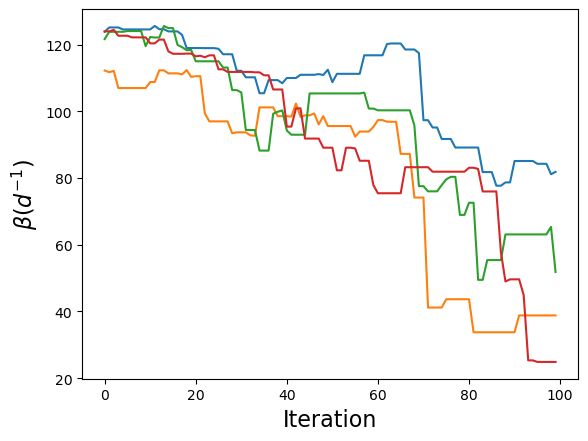

In [23]:
#== plot 4 independent chains

iparam = 0 # index of parameter to show

for chain in range( 4 ):
    plt.plot( samples_notflat[:,chain,iparam], label = 'chain {}'.format( chain + 1 ) )
    
plt.xlabel( 'Iteration', fontsize = 16 )
plt.ylabel( param_labels[iparam], fontsize = 16 )

### Posterior predictive checks (PPCs)

The code below uses posterior samples to generate replicated datasets. These replicated datasets can then be compared with actual data to check whether the fitted model can capture features of the data.

Here we ran many simulations that mimick experimental conditions (please always bear in mind that the assumed data-generating process remains an approximation of the true dynamics): 10 chickens (either broiler or backyard chickens) are caged placed together in the market and are tested at different time points for positivity to H9N2 AIV. 5 chickens are recruited at time $T_1$, while 5 chickens are recruited at time $T_0 < T_1$ and kept in an environment with no transmission until $T_1$ (when they are moved to the market). 

The figure below shows how many chickens turn positive at admission or at different time points or escape infection. This is compared with data (black dots).

The function that does so is named `simulate_experiment_multispecies_newintro`.

In [55]:
# n.b. sometimes backyard chickens are referenced with 'de' instead of 'BY'

npos_BR = [] # number of broiler chickens testing positive at different time steps
npos_BY = [] # number of backyard chickens testing positive at different time steps

nsamples = 100 # number of samples to use
seed = 0 # RNG seed
checkPts=[12,36,84] #T2-T1, T3-T2, T4-T3
Nc = 5
Ni = 5

for idx in range( nsamples ):

    beta, TE_br, TE_de, TI, TR, ilam_br, ilam_de, shape_br, shape_de, Pc_br, Pi_br, Pc_de, Pi_de = samples[idx]
    beta = beta / 24
    sigma_br = 1 / (TE_br * 24)
    sigma_de = 1 / (TE_de * 24)
    mu  = 1 / (TI * 24)
    eta = 1 / (TR * 24)
    lam_br = 1 / (ilam_br * 24)
    lam_de = 1 / (ilam_de * 24)

    sigmas = [sigma_br, sigma_de]
    pIntroInterv_br  = compute_prob_SEEIRR_gamma_dt( lam_br, shape_br, sigma_br, mu, eta, Pi_br, dt01 ).tolist()
    pIntroControl_br = compute_prob_SEEIRR_gamma_dt( lam_br, shape_br, sigma_br, mu, eta, Pc_br, 0. ).tolist()    
    pIntroInterv_de  = compute_prob_SEEIRR_gamma_dt( lam_de, shape_de, sigma_de, mu, eta, Pi_de, dt01 ).tolist()
    pIntroControl_de = compute_prob_SEEIRR_gamma_dt( lam_de, shape_de, sigma_de, mu, eta, Pc_de, 0. ).tolist()

    pIntroBulk = [ pIntroControl_br, pIntroControl_de ]  

    # simulate broilers
    npos_br_tmp = simulate_experiment_multispecies_newintro( Nsim, seed, checkPts, dtBurnin, dt01, Nc, Ni, 
                                                        pSurv, Nms, beta, sigmas, sigma_br, mu, nEstages, 
                                                        nIstages, 1., pIntroInterv_br, pIntroControl_br, 
                                                        pIntroBulk )
    npos_BR.append( npos_br_tmp )
    seed += 1

    # simulate deshi/backyard
    npos_de_tmp = simulate_experiment_multispecies_newintro( Nsim, seed, checkPts, dtBurnin, dt01, Nc, Ni, 
                                                        pSurv, Nms, beta, sigmas, sigma_de, mu, nEstages, 
                                                        nIstages, 1., pIntroInterv_de, pIntroControl_de, 
                                                        pIntroBulk )
    npos_BY.append( npos_de_tmp )
    seed += 1

npos_BR = np.array( npos_BR )    
npos_BY = np.array( npos_BY )

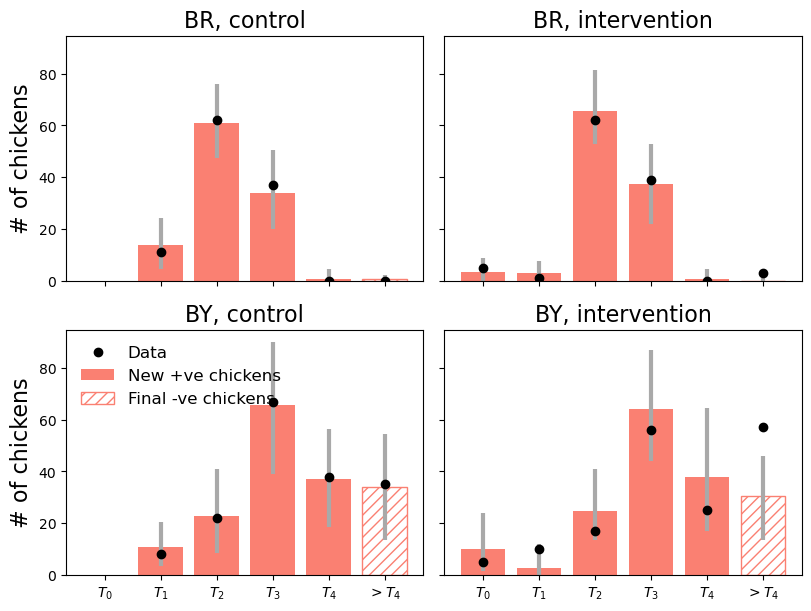

In [67]:
#=== Plot PPCs

#== process data
path_data = '../data/data_fit_counts_ct40.json' # !!! change this if Ct=33 simulations are used
with open( path_data, 'r' ) as readfile:
    data = json.load( readfile )
    
npos_BR_data  = data["npos"]["A"]['H9']
nsusc_BR_data = data["nsusc"]["A"]['H9']
npos_BY_data  = data["npos"]["B"]['H9']
nsusc_BY_data = data["nsusc"]["B"]['H9']

plot_data = { 'BR': { '0': {}, '1': {} },
              'BY': { '0': {}, '1': {} } }

plot_data['BR']['0']['ts'] = range(1,5)
plot_data['BR']['1']['ts'] = range(0,5)
plot_data['BY']['0']['ts'] = range(1,5)
plot_data['BY']['1']['ts'] = range(0,5)
plot_data['tlast'] = 5

plot_data['BR']['0']['nbirds'] = sum( npos_BR_data['0'] ) + sum( nsusc_BR_data['0'] )
plot_data['BR']['1']['nbirds'] = sum( npos_BR_data['1'] ) + sum( nsusc_BR_data['1'] )
plot_data['BY']['0']['nbirds'] = sum( npos_BY_data['0'] ) + sum( nsusc_BY_data['0'] )
plot_data['BY']['1']['nbirds'] = sum( npos_BY_data['1'] ) + sum( nsusc_BY_data['1'] )

plot_data['BR']['0']['npos'] = np.array( npos_BR_data['0'][1:] )
plot_data['BR']['1']['npos'] = np.array( npos_BR_data['1'] )
plot_data['BY']['0']['npos'] = np.array( npos_BY_data['0'][1:] )
plot_data['BY']['1']['npos'] = np.array( npos_BY_data['1'] )

plot_data['BR']['0']['nsusc_last'] = plot_data['BR']['0']['nbirds'] - sum( npos_BR_data['0'] )
plot_data['BR']['1']['nsusc_last'] = plot_data['BR']['1']['nbirds'] - sum( npos_BR_data['1'] )
plot_data['BY']['0']['nsusc_last'] = plot_data['BY']['0']['nbirds'] - sum( npos_BY_data['0'] )
plot_data['BY']['1']['nsusc_last'] = plot_data['BY']['1']['nbirds'] - sum( npos_BY_data['1'] )


#== process simulation results
Nsim = 10
nChickensBatch = 5

plot_sim = { 'BR': { '0': {}, '1': {} },
             'BY': { '0': {}, '1': {} } }

plot_sim['BR']['0']['npos'] = npos_BR[:,0,:,1:].sum( axis = 1 ) / ( Nsim * nChickensBatch )
plot_sim['BR']['1']['npos'] = npos_BR[:,1,:,: ].sum( axis = 1 ) / ( Nsim * nChickensBatch )
plot_sim['BY']['0']['npos'] = npos_BY[:,0,:,1:].sum( axis = 1 ) / ( Nsim * nChickensBatch )
plot_sim['BY']['1']['npos'] = npos_BY[:,1,:,: ].sum( axis = 1 ) / ( Nsim * nChickensBatch )

for breed in ['BR','BY']:
    for group in ['0','1']:
        plot_sim[breed][group]['npos_mean']  = plot_sim[breed][group]['npos'].mean( axis = 0 )
        plot_sim[breed][group]['npos_low']   = plot_sim[breed][group]['npos_mean'] - np.percentile( plot_sim[breed][group]['npos'],  2.5, axis = 0 )
        plot_sim[breed][group]['npos_high']  = np.percentile( plot_sim[breed][group]['npos'], 97.5, axis = 0 ) - plot_sim[breed][group]['npos_mean']
        
        escape = 1. - plot_sim[breed][group]['npos'].sum( axis = 1 )
        
        plot_sim[breed][group]['p_escape_mean']  = escape.mean()
        plot_sim[breed][group]['p_escape_low']   = plot_sim[breed][group]['p_escape_mean'] - np.percentile( escape, 2.5 )
        plot_sim[breed][group]['p_escape_high']  = np.percentile( escape, 97.5 ) - plot_sim[breed][group]['p_escape_mean']
        
#=== plot results

fig, ax = plt.subplots( figsize = ( 8, 6 ), ncols = 2, nrows = 2, sharex = True,
                      sharey = True, constrained_layout = True )

fcolor = 'salmon'

for irow, breed in enumerate( [ 'BR', 'BY' ] ):
    for icol, group in enumerate( [ '0', '1' ] ):
        
        # general stuff
        axi = ax[irow][icol]
        
        ts     = plot_data[breed][group]['ts']
        tlast  = plot_data['tlast']
        nbirds = plot_data[breed][group]['nbirds'] 
        
        # plot sim
        npos_sim = plot_sim[breed][group]['npos_mean'] * nbirds
        npos_err_sim = np.vstack( [ plot_sim[breed][group]['npos_low'] * nbirds,
                                    plot_sim[breed][group]['npos_high'] * nbirds ] )
        
        nsusc_sim = plot_sim[breed][group]['p_escape_mean'] * nbirds
        nsusc_err_sim = np.array( [ plot_sim[breed][group]['p_escape_low'] * nbirds,
                                    plot_sim[breed][group]['p_escape_high'] * nbirds ] )[:,None]
        axi.bar( ts, npos_sim, yerr = npos_err_sim, color = fcolor,
                 error_kw=dict( ecolor='darkgrey', lw=3 ), label = 'New +ve chickens',
               zorder = -1)
        
        axi.bar( tlast, nsusc_sim, yerr = nsusc_err_sim, color = fcolor,
                 error_kw=dict( ecolor='darkgrey', lw=3 ), fc = 'white', ec = fcolor, hatch = '///',
                 label = 'Final -ve chickens', zorder = -1 )
        
        # plot data 
        npos_data = plot_data[breed][group]['npos']
        
        
        nsusc_data = plot_data[breed][group]['nsusc_last']
        
        axi.scatter( ts, npos_data, color = 'black', label = 'Data' )
    
        axi.scatter( tlast, nsusc_data, color = 'black' )
        
    
ax[0,0].set_ylabel( '# of chickens', fontsize = 16 )
ax[1,0].set_ylabel( '# of chickens', fontsize = 16 )
ax[1,0].set_xticks(range(6))
ax[1,0].set_xticklabels([r'$T_0$',r'$T_1$',r'$T_2$',r'$T_3$',r'$T_4$',r'$>T_4$'])
ax[1,1].set_xticks(range(6))
ax[1,1].set_xticklabels([r'$T_0$',r'$T_1$',r'$T_2$',r'$T_3$',r'$T_4$',r'$>T_4$'])
ax[1,0].legend( framealpha = False, fontsize = 12, loc = 2 )

titles  = ['BR, control', 'BR, intervention', 'BY, control', 'BY, intervention']
for iax, axi in enumerate( ax.flatten() ):
    axi.set_title( titles[iax], fontsize = 16 )

### Introductions

The code below calculates the probability $P(X)$ that a chicken enters the market in each compartment $X \in \{S,E_1,E_2,I,R_1,R_2\}$ through the function `compute_prob_SEEIRR_gamma_dt`.

The analysis is repeated for each MCMC sample and for any combination of chicken type (broiler: **BR**, deshi/backyard: **BY**) and experiment arm (control: **c**, intervention: **i**).

These probabilities can be used to calculate the proportion of chickens:

- With an active infection: $P(E_1)+P(E_2)+P(I)$
- That are already immune to AIV: $P(R_1) + P(R_2)$
- That would test positive to AIV: $P(I) + P(R_1)$

Text(0, 0.5, 'Density')

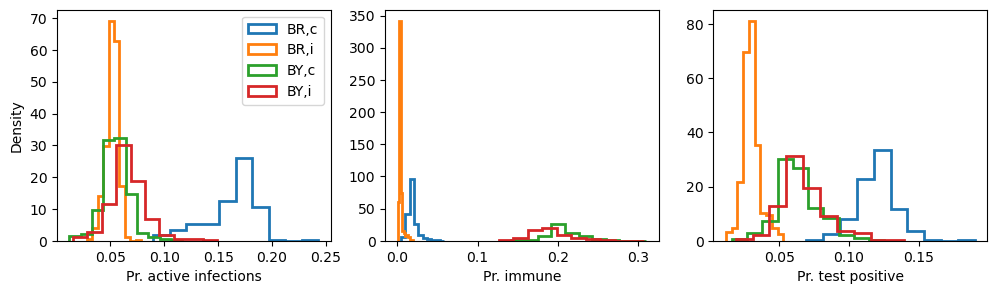

In [32]:
pIntroPos  = []
pIntroExposed = []

pIntroE = []
pIntroI = []
pIntroRpos = []
pIntroRneg = []

dts = { 'c': 0., 'i': 60. / 24 }
    
fig, ax = plt.subplots( figsize = ( 12, 3 ), ncols = 3 )

for breed in ['BR','BY']:
    for group in ['c','i']:
        
        # select appropriate parameters for breed&group combination
        if breed == 'BR':
            isigma = 1
            ilam = 5
            ikappa = 7
            if group == 'c':
                iP = 9
            else:
                iP = 10
        else:
            isigma = 2
            ilam = 6
            ikappa = 8
            if group == 'c':
                iP = 11
            else:
                iP = 12

        lams   = 1. / samples[:,ilam]
        sigmas = 1. / samples[:,isigma]
        mus    = 1. / samples[:,3]
        etas   = 1. / samples[:,4]
        shapes = samples[:,7]
        Ps     = samples[:,iP]

        probsX = []
        for args in zip( lams, sigmas, mus, etas, shapes, Ps ):
            lam, sigma, mu, eta, shape, p = args
            probsX.append( compute_prob_SEEIRR_gamma_dt( lam, shape, sigma, mu, eta, p, dts[group] ) )

        probsX = np.array( probsX )

        pIntroActive    = probsX[:,[1,2,3]].sum( axis = 1 ).tolist()
        pIntroImmune    = probsX[:,[4,5]].sum( axis = 1 ).tolist()
        pIntroPositive  = probsX[:,[3,4]].sum( axis = 1 ).tolist()
        
        # Plot histogram
        ax[0].hist( pIntroActive, histtype = 'step', density = True, lw = 2,
                  label = '{},{}'.format( breed, group ) )
        ax[1].hist( pIntroImmune, histtype = 'step', density = True, lw = 2 )
        ax[2].hist( pIntroPositive, histtype = 'step', density = True, lw = 2 )
        
        
ax[0].legend()
ax[0].set_xlabel( 'Pr. active infections' )
ax[1].set_xlabel( 'Pr. immune' )
ax[2].set_xlabel( 'Pr. test positive' )
ax[0].set_ylabel( 'Density' )              

### Measuring probability of exposure

The code below calculates the probability that a chicken that is susceptible when it enters the market remains uninfected after spending $t$ hours at the market.

The idea is to consider a large number `Nchickens = 1000000` of *test* chickens that 'sit' in the market and measure how long it takes for them to become infected. *Test* chickens can become infected but do not contribute to transmission and cannot be sold.

The function to do so is named `measure_exposure_multispecies`.

In [41]:
nsusc = [] # number of chickens 
nsamples = 100 # use this number of samples
seed = 0 # RNG seed

Tmax = 24*5 # max simulation time (in hours)

for idx in range( nsamples ):

    beta, TE_br, TE_de, TI, TR, ilam_br, ilam_de, shape_br, shape_de, Pc_br, Pi_br, Pc_de, Pi_de = samples[idx]

    # convert to h or h^-1
    beta = beta / 24
    sigma_br = 1 / (TE_br * 24)
    sigma_de = 1 / (TE_de * 24)
    mu  = 1 / (TI * 24)
    eta = 1 / (TR * 24)
    lam_br = 1 / (ilam_br * 24)
    lam_de = 1 / (ilam_de * 24)

    # calculate intro probabilities
    sigmas = [sigma_br, sigma_de]
    pIntroControl_br = compute_prob_SEEIRR_gamma_dt( lam_br, shape_br, sigma_br, mu, eta, Pc_br, 0. ).tolist()    
    pIntroControl_de = compute_prob_SEEIRR_gamma_dt( lam_de, shape_de, sigma_de, mu, eta, Pc_de, 0. ).tolist()
    pIntroBulk = [ pIntroControl_br, pIntroControl_de ]  

    # perform Nsim independent simulations with Nchickens test chickens each per sample
    # Tmax is the maximum simulation time
    nsusc_tmp = measure_exposure_multispecies( Nsim, seed, Tmax, dtBurnin, Nchickens, 
                                               pSurv, Nms, beta, sigmas, sigma_br, mu, nEstages, 
                                               nIstages, pIntroBulk )
    seed += 1

    nsusc.append( nsusc_tmp )

nsusc = np.array( nsusc )

nsusc.shape # an array with dimensions (nsamples, Nsim, Tmax)

(100, 10, 120)

(0.0, 1.0)

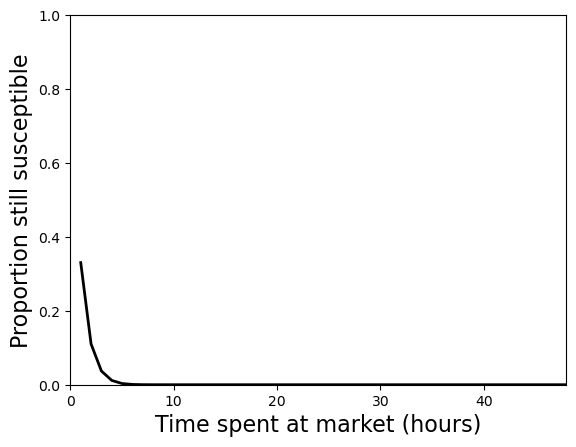

In [44]:
#== plot mean probability of becoming infected 
# Average over MCMC samples and simulations
pS = np.mean( nsusc / Nchickens, axis = ( 0, 1 ) ) 
plt.plot( range( 1, Tmax + 1 ), pS, color = 'black', lw = 2 )
plt.xlabel( 'Time spent at market (hours)', fontsize = 16 )
plt.ylabel( 'Proportion still susceptible', fontsize = 16 )

plt.xlim( 0, 48 )
plt.ylim( 0, 1 )

## Interventions

This section illustrates how to simulate various types of interventions aiming to reduce H9N2 AIV circulation in the market. The function `simulate_market` simulates AIV dynamics and returns numbers of chickens in different compartments. 

For any type of intervention, we measure the effectiveness of any intervention by the reduction in daily cumulative prevalence with respect to a scenario where no intervention is applied. Mathematically:

$$\text{Effectiveness} = \dfrac{I_0 - I_{interv}}{I_0}$$

Where $I_{interv}$ and $I_0$ denote cumulative prevalence (over one day) with and without an intervention, respectively.

### Reduced length of stay

Chickens are allowed to stay in the market for up to $T_m$ hours since they are first offered for sale. The survival time distribution remains the same until $T_m$ but $Pr(\text{length of stay}>T_m)=0$

### Reduced probability of prior exposure

Chickens entering the market have a reduced probability $\rho \rightarrow (1-r)\rho$ of being already exposed to AIV.

The code below combines both measures.

In [68]:
def truncate_psurv( icdf, dt ):
    '''
    Used to truncate the length of stay distribution to dt.
    Returns the truncated survival distribution.
    '''
    dt1 = ( dt // 24 + 1) * 24 # length of new icdf must be a multiple of 24 (+1)
    
    res = np.zeros( dt1 + 1 )
    
    res[:dt+1] = icdf[:dt+1]
    
    return res

In [78]:
nsamples = 100 # number of samples to use
seed = 0 # RNG seed 
Tmax = 50 * 24

#= create new length of stay survival function 
pSurv_interv = truncate_psurv( pSurv.copy(), 24 ) # set maximum length of stay to 24 hours

#= set reduction of probability of prior exposure
rr = 0.6 # reduces probability of prior exposure ρ to (1-rr)*ρ


cumPrevalence = { 'baseline': [],
                  'intervention': [] }

for idx in range( nsamples ):

    beta, TE_br, TE_de, TI, TR, ilam_br, ilam_de, shape_br, shape_de, Pc_br, Pi_br, Pc_de, Pi_de = samples[idx]
    beta = beta / 24
    sigma_br = 1 / (TE_br * 24)
    sigma_de = 1 / (TE_de * 24)
    mu  = 1 / (TI * 24)
    eta = 1 / (TR * 24)
    lam_br = 1 / (ilam_br * 24)
    lam_de = 1 / (ilam_de * 24)

    sigmas = [sigma_br, sigma_de]

    #== simulate baseline (no intervention)

    pIntroControl_br = compute_prob_SEEIRR_gamma_dt( lam_br, shape_br, sigma_br, mu, eta, Pc_br, 0. ).tolist()    
    pIntroControl_de = compute_prob_SEEIRR_gamma_dt( lam_de, shape_de, sigma_de, mu, eta, Pc_de, 0. ).tolist()
    pIntroBulk = [ pIntroControl_br, pIntroControl_de ]  

    comps0 = simulate_market( Nsim, seed, Tmax, pSurv, Nms, 
                             beta, sigmas, mu, nEstages, nIstages, pIntroBulk )
    comps0 = np.array( comps0 )
    
    # sum total prevalence (I) over the last 24 hours of simulation
    Itot0 = comps0[:,-24:,3].sum( axis = 1 ).tolist()
    
    cumPrevalence['baseline'].extend( Itot0 )
    
    seed += 1 
    
    #== simulate intervention

    # apply reduction to probability of prior exposure
    pIntroControl_br = compute_prob_SEEIRR_gamma_dt( lam_br, shape_br, sigma_br, mu, eta, ( 1 - rr ) * Pc_br, 0. ).tolist()    
    pIntroControl_de = compute_prob_SEEIRR_gamma_dt( lam_de, shape_de, sigma_de, mu, eta, ( 1 - rr ) * Pc_de, 0. ).tolist()
    pIntroBulk = [ pIntroControl_br, pIntroControl_de ]  

    comps = simulate_market( Nsim, seed, Tmax, pSurv_interv.tolist(), Nms, 
                             beta, sigmas, mu, nEstages, nIstages, pIntroBulk )
    comps = np.array( comps )
    
    # sum total prevalence (I) over the last 24 hours of simulation
    Itot = comps[:,-24:,3].sum( axis = 1 ).tolist()
    cumPrevalence['intervention'].extend( Itot )
    
    seed += 1 

Effectiveness: 0.3625340976567789


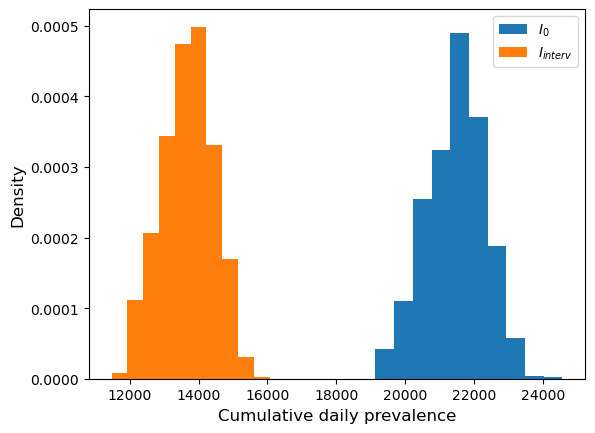

In [84]:
#== Plot the distribution of cumulative daily prevalence in both scenarios

plt.hist( cumPrevalence['baseline'], label = r'$I_0$', density = True ) # w/out intervention
plt.hist( cumPrevalence['intervention'], label = r'$I_{interv}$', density = True ) # w/ intervention

print( 'Effectiveness:', 1. -  np.mean( cumPrevalence['intervention'] ) / np.mean( cumPrevalence['baseline'] ) )

plt.xlabel( 'Cumulative daily prevalence', fontsize = 12 )
plt.ylabel( 'Density', fontsize = 12 )
plt.legend()

### Vaccination

A proportion of chickens are vaccinated against AIV and are assumed to be completely immune to AIV. These chickens move automatically from the $S$ to the $R_2$ compartment.  

In [85]:
nsamples = 100 # number of samples to use
seed = 0 # RNG seed 
Tmax = 50 * 24
vax = 0.5 # set proportion of vaxxed chickens

cumPrevalence = { 'baseline': [],
                  'intervention': [] }

for idx in range( nsamples ):

    beta, TE_br, TE_de, TI, TR, ilam_br, ilam_de, shape_br, shape_de, Pc_br, Pi_br, Pc_de, Pi_de = samples[idx]
    beta = beta / 24
    sigma_br = 1 / (TE_br * 24)
    sigma_de = 1 / (TE_de * 24)
    mu  = 1 / (TI * 24)
    eta = 1 / (TR * 24)
    lam_br = 1 / (ilam_br * 24)
    lam_de = 1 / (ilam_de * 24)

    sigmas = [sigma_br, sigma_de]

    #== simulate baseline (no intervention)

    pIntroControl_br = compute_prob_SEEIRR_gamma_dt( lam_br, shape_br, sigma_br, mu, eta, Pc_br, 0. ).tolist()    
    pIntroControl_de = compute_prob_SEEIRR_gamma_dt( lam_de, shape_de, sigma_de, mu, eta, Pc_de, 0. ).tolist()
    pIntroBulk = [ pIntroControl_br, pIntroControl_de ]  

    comps0 = simulate_market( Nsim, seed, Tmax, pSurv, Nms, 
                             beta, sigmas, mu, nEstages, nIstages, pIntroBulk )
    comps0 = np.array( comps0 )
    
    # sum total prevalence (I) over the last 24 hours of simulation
    Itot0 = comps0[:,-24:,3].sum( axis = 1 ).tolist()
    
    cumPrevalence['baseline'].extend( Itot0 )
    
    seed += 1 
    
    #== simulate intervention

    # calculate intro probability without vaccination
    pIntroControl_br = compute_prob_SEEIRR_gamma_dt( lam_br, shape_br, sigma_br, mu, eta, Pc_br, 0. )  
    pIntroControl_de = compute_prob_SEEIRR_gamma_dt( lam_de, shape_de, sigma_de, mu, eta, Pc_de, 0. )
    # apply pre-emptive vaccination
    pIntroControl_br = pIntroControl_br * ( 1 - vax ) + np.array( [0]*(2+nEstages+nIstages) + [vax] )
    pIntroControl_de = pIntroControl_de * ( 1 - vax ) + np.array( [0]*(2+nEstages+nIstages) + [vax] )
    pIntroBulk = [ pIntroControl_br, pIntroControl_de ]  

    comps = simulate_market( Nsim, seed, Tmax, pSurv, Nms, 
                             beta, sigmas, mu, nEstages, nIstages, pIntroBulk )
    comps = np.array( comps )
    
    # sum total prevalence (I) over the last 24 hours of simulation
    Itot = comps[:,-24:,3].sum( axis = 1 ).tolist()
    cumPrevalence['intervention'].extend( Itot )
    
    seed += 1 

Effectiveness: 0.5227449133610835


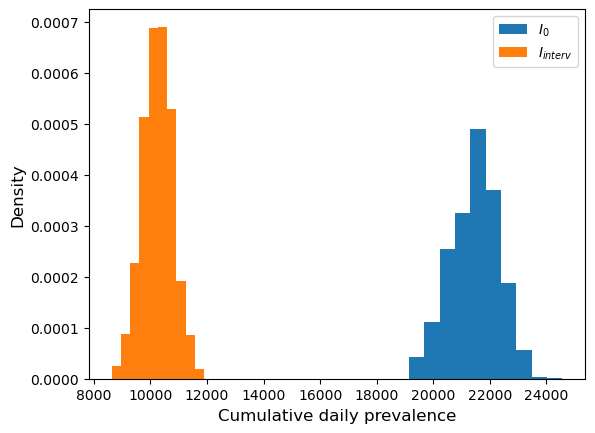

In [86]:
#== Plot the distribution of cumulative daily prevalence in both scenarios

plt.hist( cumPrevalence['baseline'], label = r'$I_0$', density = True ) # w/out intervention
plt.hist( cumPrevalence['intervention'], label = r'$I_{interv}$', density = True ) # w/ intervention

print( 'Effectiveness:', 1. -  np.mean( cumPrevalence['intervention'] ) / np.mean( cumPrevalence['baseline'] ) )

plt.xlabel( 'Cumulative daily prevalence', fontsize = 12 )
plt.ylabel( 'Density', fontsize = 12 )
plt.legend()

# Environmental transmission

Here we consider an alternative scenario where transmission is mediated by environmental contamination shed by infectious chickens. With direct transmission, the force of infection (FOI) is given by:

$$FOI_{dir}(t) = 1 - e^{-\beta I_(t)/N}$$

where $I(t)$ is prevalence (# of infected chickens) and $N$ is a scaling constant. For environmental transmission instead:

$$FOI_{env}(t) = 1 - e^{-\beta_{env} I_{env}(t)/N}$$

Where $I_{env}(t)$ is the current environmental load. We measure $I_{env}(t)$ in arbitrary units: we assume that every infectious chicken sheds a single unit of contaminated material per time step; each of these units then decays with probability $1-e^{-\Theta}$ per time step, where $\Theta$ is the decay rate of AIV in the environment. The dynamics of the environmental load is then given by:

$$I_{env}(t + 1) = I_{env}(t) + I_{tot}(t) - Binom( n = I_{env}(t), p = 1-e^{-\Theta})$$

As explained in the main manuscript, we did not fit this model to data. Instead, we used MCMC samples obtained under direct transmission to calculate an *equivalent* value of $\beta_{env}$ that yields prevalence levels that are similar to direct transmission with  transmission rate $\beta$. For a fixed value of $\Theta$, the mapping is (more details in the manuscript):

$$\beta_{env} = \beta ( 1 - e^{-\Theta} )$$

The code below shows that this mapping indeed reproduces the same levels of prevalence observed with direct transmission. The function that simulates AIV dynamics with direct transmission is named `simulate_market_environment`, as opposed to `simulate_market` that assumes direct transmission.

In [107]:
seed = 0 # RNG seed 
nsamples = 100 # number of posterior samples to use
decay_rate = 0.014 # decay rate Θ
TmaxEnv = 24 * 50 # long duration to allow for stationariety


prevalence = {
    'direct': [],
    'environment': []
}

for idx in range( nsamples ):

    beta, TE_br, TE_de, TI, TR, ilam_br, ilam_de, shape_br, shape_de, Pc_br, Pi_br, Pc_de, Pi_de = samples[idx]
    beta = beta / 24
    sigma_br = 1 / (TE_br * 24)
    sigma_de = 1 / (TE_de * 24)
    mu  = 1 / (TI * 24)
    eta = 1 / (TR * 24)
    lam_br = 1 / (ilam_br * 24)
    lam_de = 1 / (ilam_de * 24)

    sigmas = [sigma_br, sigma_de]

    pIntroControl_br = compute_prob_SEEIRR_gamma_dt( lam_br, shape_br, sigma_br, mu, eta, Pc_br, 0. ).tolist()    
    pIntroControl_de = compute_prob_SEEIRR_gamma_dt( lam_de, shape_de, sigma_de, mu, eta, Pc_de, 0. ).tolist()
    pIntroBulk = [ pIntroControl_br, pIntroControl_de ]  

    #== simulate compartments with DIRECT TRANSMISSION
    comps = simulate_market( Nsim, seed, TmaxEnv, pSurv, Nms, 
                             beta, sigmas, 
                             mu, nEstages, nIstages, pIntroBulk )

    comps = np.array( comps )
    I  = comps[:,:,3] / comps[:,:,:].sum( axis = -1 )
    prevalence['direct'].append( I[:,-96:].tolist() ) # select last 4 days
    
    seed += 1
    
    #== simulate compartments with ENVIRONMENTAL CONTAMINATION
    
    beta_env = beta * ( 1 - np.exp( - decay_rate ) ) # map beta to beta_env
    
    comps = simulate_market_environment( Nsim, seed, TmaxEnv, pSurv, Nms, 
                                         beta_env, decay_rate, sigmas, 
                                         mu, nEstages, nIstages, pIntroBulk )
    
    comps = np.array( comps )
    I  = comps[:,:,3] / comps[:,:,:-1].sum( axis = -1 ) # the last compartment is the environment
    prevalence['environment'].append( I[:,-96:].tolist() ) # select last 4 days

    seed += 1
    
prevalence['direct'] = np.array( prevalence['direct'] )
prevalence['environment'] = np.array( prevalence['environment'] )


Text(0, 0.5, 'Prop. infectious chickens')

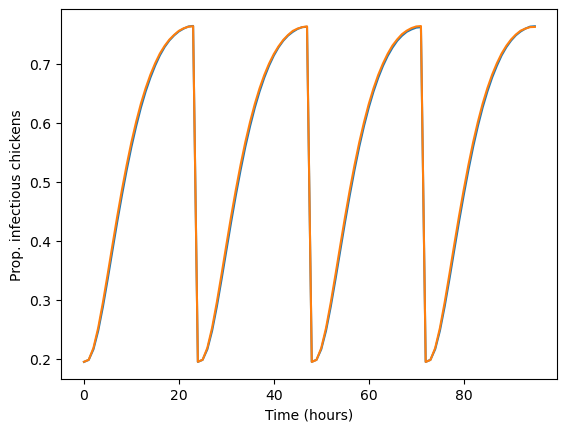

In [109]:
#== plot prevalence over 4 days to check that both mechanisms yield similar levels of prevalence

plt.plot( prevalence['direct'].mean( axis = ( 0, 1 ) ), label = 'Dir.' )
plt.plot( prevalence['environment'].mean( axis = ( 0, 1 ) ), label = 'Env.' )
plt.xlabel( 'Time (hours)' )
plt.ylabel( 'Prop. infectious chickens' )
plt.legend()

## Disinfection and market closure

While both direct and environmental transmission yield similar stationary AIV dynamics, these assumptions lead to different scenarios when this dynamics is perturbed.

Here we consider a one-shot intervention that closes the market for one day: all chickens are removed from the simulation (and never offered for sale again after the market reopens) and the market is deep-cleaned, i.e. AIV environmental load is set to 0.

Functions to do this are named `simulate_market_withclosure` and `simulate_market_environment_withclosure`, which assume direct and environmental transmission respectively.

The plot below should show that prevalence builds up more slowly after the intervention under envoronmental transmission than under direct transmission.

In [111]:
seed = 0 # RNG seed 
nsamples = 100 # number of posterior samples to use
decay_rate = 0.014 # decay rate Θ
TmaxEnv2 = 24 * 100
Tclose, Treopen = 90*24 - 1, 90*24

prevalence = {
    'direct': [],
    'environment': []
}

for idx in range( nsamples ):

    beta, TE_br, TE_de, TI, TR, ilam_br, ilam_de, shape_br, shape_de, Pc_br, Pi_br, Pc_de, Pi_de = samples[idx]
    beta = beta / 24
    sigma_br = 1 / (TE_br * 24)
    sigma_de = 1 / (TE_de * 24)
    mu  = 1 / (TI * 24)
    eta = 1 / (TR * 24)
    lam_br = 1 / (ilam_br * 24)
    lam_de = 1 / (ilam_de * 24)

    sigmas = [sigma_br, sigma_de]

    pIntroControl_br = compute_prob_SEEIRR_gamma_dt( lam_br, shape_br, sigma_br, mu, eta, Pc_br, 0. ).tolist()    
    pIntroControl_de = compute_prob_SEEIRR_gamma_dt( lam_de, shape_de, sigma_de, mu, eta, Pc_de, 0. ).tolist()
    pIntroBulk = [ pIntroControl_br, pIntroControl_de ]  

    #== simulate compartments with DIRECT TRANSMISSION
    comps = simulate_market_withclosure( Nsim, seed, TmaxEnv2, pSurv, Nms, 
                                         beta, sigmas, mu, nEstages, nIstages, pIntroBulk,
                                         Tclose, Treopen )
    comps = np.array( comps )
    prevalence['direct'].append( np.array( comps )[:,Treopen:,3].tolist() )

    seed += 1
    
    #== simulate compartments with ENVIRONMENTAL CONTAMINATION
    
    beta_env = beta * ( 1 - np.exp( - decay_rate ) ) # map beta to beta_env
    
    comps = simulate_market_environment_withclosure( Nsim, seed, TmaxEnv2, pSurv, Nms, 
                                            beta_env, decay_rate, sigmas, 
                                            mu, nEstages, nIstages, pIntroBulk,
                                            Tclose, Treopen, 1. )
    
    
    comps = np.array( comps )
    prevalence['environment'].append( np.array( comps )[:,Treopen:,3].tolist() )
    
    seed += 1
    
prevalence['direct'] = np.array( prevalence['direct'] )
prevalence['environment'] = np.array( prevalence['environment'] )

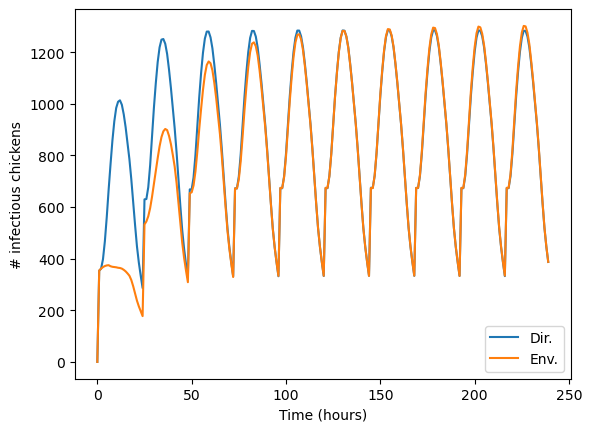

In [113]:
#== plot number of infectious chickens

plt.plot( prevalence['direct'].mean( axis = ( 0, 1 ) ), label = 'Dir.' )
plt.plot( prevalence['environment'].mean( axis = ( 0, 1 ) ), label = 'Env.' )
plt.xlabel( 'Time (hours)' )
plt.ylabel( '# infectious chickens' )
plt.legend()

## Routine disinfection

Here we consider a final intervention (routine disinfection) where AIV environmental load is reduced by $x%$ every 24 hours. Effectiveness is measured in the same way as defined above.

Setting the last argument of the function `simulate_market_environment` to any value $0<x\leq 1$ introduces daily disinfection with $x%$ of contamination removed every day.

In [116]:
nsamples = 100 # number of samples to use
seed = 0 # RNG seed 
decay_rate = 0.014 # decay rate Θ
TmaxEnv3 = 24 * 120 # max simulation time
disinfection = 0.7 # proportion of environmental load removed every day

cumPrevalence = { 'baseline': [],
                  'intervention': [] }

for idx in range( nsamples ):

    beta, TE_br, TE_de, TI, TR, ilam_br, ilam_de, shape_br, shape_de, Pc_br, Pi_br, Pc_de, Pi_de = samples[idx]
    beta = beta / 24
    beta_env = beta * ( 1. - np.exp( -decay_rate ) )
    sigma_br = 1 / (TE_br * 24)
    sigma_de = 1 / (TE_de * 24)
    mu  = 1 / (TI * 24)
    eta = 1 / (TR * 24)
    lam_br = 1 / (ilam_br * 24)
    lam_de = 1 / (ilam_de * 24)

    sigmas = [sigma_br, sigma_de]

    #== simulate baseline (no intervention)

    pIntroControl_br = compute_prob_SEEIRR_gamma_dt( lam_br, shape_br, sigma_br, mu, eta, Pc_br, 0. ).tolist()    
    pIntroControl_de = compute_prob_SEEIRR_gamma_dt( lam_de, shape_de, sigma_de, mu, eta, Pc_de, 0. ).tolist()
    pIntroBulk = [ pIntroControl_br, pIntroControl_de ]  

    comps0 = simulate_market_environment( Nsim, seed, TmaxEnv3, pSurv, Nms, 
                                          beta_env, decay_rate, sigmas, 
                                          mu, nEstages, nIstages, pIntroBulk )
    comps0 = np.array( comps0 )
    
    # sum total prevalence (I) over the last 24 hours of simulation
    Itot0 = comps0[:,-24:,3].sum( axis = 1 ).tolist()
    
    cumPrevalence['baseline'].extend( Itot0 )
    
    seed += 1 
    
    #== simulate intervention (routine disinfection)

    comps = simulate_market_environment( Nsim, seed, TmaxEnv3, pSurv, Nms, 
                                          beta_env, decay_rate, sigmas, 
                                          mu, nEstages, nIstages, pIntroBulk, disinfection )
    comps = np.array( comps )
    
    # sum total prevalence (I) over the last 24 hours of simulation
    Itot = comps[:,-24:,3].sum( axis = 1 ).tolist()
    cumPrevalence['intervention'].extend( Itot )
    
    seed += 1 

Effectiveness: 0.21929387652496146


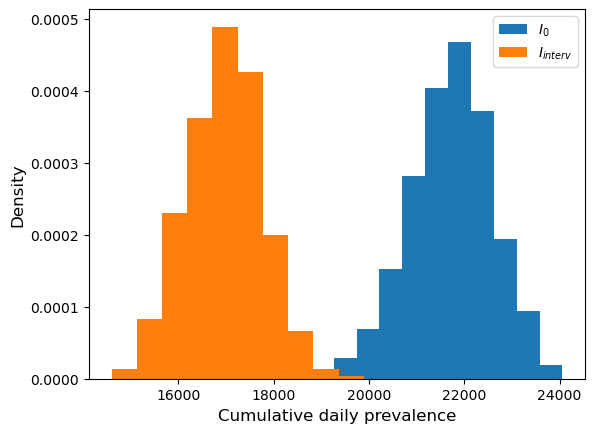

In [118]:
#== Plot the distribution of cumulative daily prevalence in both scenarios

plt.hist( cumPrevalence['baseline'], label = r'$I_0$', density = True ) # w/out intervention
plt.hist( cumPrevalence['intervention'], label = r'$I_{interv}$', density = True ) # w/ intervention

print( 'Effectiveness:', 1. -  np.mean( cumPrevalence['intervention'] ) / np.mean( cumPrevalence['baseline'] ) )

plt.xlabel( 'Cumulative daily prevalence', fontsize = 12 )
plt.ylabel( 'Density', fontsize = 12 )
plt.legend()